### * **What is a phishing attack?**
* Phishing is a type of social engineering attack often used to steal user data, including login credentials and credit card numbers. It occurs when an attacker, masquerading as a trusted entity, dupes a victim into opening an email, instant message, or text message. 

##### * Importing some useful libraries

In [12]:
!pip install selenium

You should consider upgrading via the 'C:\Users\hp\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [13]:
import pandas as pd # use for data manipulation and analysis
import numpy as np # use for multi-dimensional array and matrix

import seaborn as sns # use for high-level interface for drawing attractive and informative statistical graphics 
import matplotlib.pyplot as plt # It provides an object-oriented API for embedding plots into applications
%matplotlib inline 
# It sets the backend of matplotlib to the 'inline' backend:
import plotly.express as px
import time # calculate time 

from sklearn.linear_model import LogisticRegression # algo use to predict good or bad
from sklearn.naive_bayes import MultinomialNB # nlp algo use to predict good or bad

from sklearn.model_selection import train_test_split # spliting the data between feature and target
from sklearn.metrics import classification_report # gives whole report about metrics (e.g, recall,precision,f1_score,c_m)
from sklearn.metrics import confusion_matrix # gives info about actual and predict
from nltk.tokenize import RegexpTokenizer # regexp tokenizers use to split words from text  
from nltk.stem.snowball import SnowballStemmer # stemmes words
from sklearn.feature_extraction.text import CountVectorizer # create sparse matrix of words using regexptokenizes  
from sklearn.pipeline import make_pipeline # use for combining all prerocessors techniuqes and algos

from PIL import Image # getting images in notebook
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator# creates words colud

from bs4 import BeautifulSoup # use for scraping the data from website
from selenium import webdriver # use for automation chrome 
import networkx as nx # for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.

import pickle# use to dump model 

import warnings # ignores pink warnings 
warnings.filterwarnings('ignore')

In [14]:
# Loading the dataset
phish_data = pd.read_csv('phishing_site_urls.csv')

In [15]:
phish_data.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [16]:
phish_data.tail()

,URL,Label
549341,23.227.196.215/,bad
549342,apple-checker.org/,bad
549343,apple-iclods.org/,bad
549344,apple-uptoday.org/,bad
549345,apple-search.info,bad


In [17]:
phish_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549346 non-null  object
 1   Label   549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


In [18]:
phish_data.isnull().sum() # there is no missing values

URL      0
Label    0
dtype: int64

* **Since it is classification problems so let's see the classes are balanced or imbalances**

In [19]:
#create a dataframe of classes counts
label_counts = pd.DataFrame(phish_data.Label.value_counts())

In [20]:
#visualizing target_col
fig = px.bar(label_counts, x=label_counts.index, y=label_counts.Label)
fig.show()

### Preprocessing
* **Now that we have the data, we have to vectorize our URLs. I used CountVectorizer and gather words using tokenizer, since there are words in urls that are more important than other words e.g ‘virus’, ‘.exe’ ,’.dat’ etc. Lets convert the URLs into a vector form.**

#### RegexpTokenizer
* A tokenizer that splits a string using a regular expression, which matches either the tokens or the separators between tokens.

In [21]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')#to getting alpha only

In [22]:
phish_data.URL[0]

'nobell.it/70ffb52d079109dca5664cce6f317373782/login.SkyPe.com/en/cgi-bin/verification/login/70ffb52d079109dca5664cce6f317373/index.php?cmd=_profile-ach&outdated_page_tmpl=p/gen/failed-to-load&nav=0.5.1&login_access=1322408526'

In [23]:
# this will be pull letter which matches to expression
tokenizer.tokenize(phish_data.URL[0]) # using first row

['nobell',
 'it',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'login',
 'SkyPe',
 'com',
 'en',
 'cgi',
 'bin',
 'verification',
 'login',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'index',
 'php',
 'cmd',
 'profile',
 'ach',
 'outdated',
 'page',
 'tmpl',
 'p',
 'gen',
 'failed',
 'to',
 'load',
 'nav',
 'login',
 'access']

In [24]:
print('Getting words tokenized ...')
t0= time.perf_counter()
phish_data['text_tokenized'] = phish_data.URL.map(lambda t: tokenizer.tokenize(t)) # doing with all rows
t1 = time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting words tokenized ...
Time taken 2.218552499999987 sec


In [25]:
phish_data.sample(5)

,URL,Label,text_tokenized
150157,blixtech.com/stories/0WnMn8aFJ4Cs,good,"[blixtech, com, stories, WnMn, aFJ, Cs]"
27886,welchmediadevelopers.com/wp-content/themes/twe...,bad,"[welchmediadevelopers, com, wp, content, theme..."
467412,wwoofjapan.com/main/index.php?option=com_conte...,good,"[wwoofjapan, com, main, index, php, option, co..."
183951,entertainment.howstuffworks.com/kid-nichols-ho...,good,"[entertainment, howstuffworks, com, kid, nicho..."
395543,mylife.com/c-1442108366,good,"[mylife, com, c]"


#### SnowballStemmer
* Snowball is a small string processing language, gives root words

In [26]:
stemmer = SnowballStemmer("english") # choose a language

In [27]:
print('Getting words stemmed ...')
t0= time.perf_counter()
phish_data['text_stemmed'] = phish_data['text_tokenized'].map(lambda l: [stemmer.stem(word) for word in l])
t1= time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting words stemmed ...
Time taken 23.08872600000001 sec


In [28]:
phish_data.sample(5)

,URL,Label,text_tokenized,text_stemmed
274662,amazon.com/Dance-Fleetwood-Mac/dp/B000002NHG,good,"[amazon, com, Dance, Fleetwood, Mac, dp, B, NHG]","[amazon, com, danc, fleetwood, mac, dp, b, nhg]"
17863,huarui-tec.com/js/?ref=fnxlefqus.battle.net/d3...,bad,"[huarui, tec, com, js, ref, fnxlefqus, battle,...","[huarui, tec, com, js, ref, fnxlefqus, battl, ..."
442063,tcoasttalk.com/2011/09/06/woman-in-jensen-beac...,good,"[tcoasttalk, com, woman, in, jensen, beach, wo...","[tcoasttalk, com, woman, in, jensen, beach, wo..."
183610,english.turkcebilgi.com/Lillian+Moller+Gilbreth,good,"[english, turkcebilgi, com, Lillian, Moller, G...","[english, turkcebilgi, com, lillian, moller, g..."
405079,nick.com/videos/penguins-of-madagascar-videos,good,"[nick, com, videos, penguins, of, madagascar, ...","[nick, com, video, penguin, of, madagascar, vi..."


In [29]:
print('Getting joiningwords ...')
t0= time.perf_counter()
phish_data['text_sent'] = phish_data['text_stemmed'].map(lambda l: ' '.join(l))
t1= time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting joiningwords ...
Time taken 0.16629320000001258 sec


In [30]:
phish_data.sample(5)

,URL,Label,text_tokenized,text_stemmed,text_sent
218594,music.yahoo.com/tsuyoshi-nagabuchi/photos/,good,"[music, yahoo, com, tsuyoshi, nagabuchi, photos]","[music, yahoo, com, tsuyoshi, nagabuchi, photo]",music yahoo com tsuyoshi nagabuchi photo
438735,startrek.com/database_article/year-of-hell-par...,good,"[startrek, com, database, article, year, of, h...","[startrek, com, databas, articl, year, of, hel...",startrek com databas articl year of hell part ii
240858,soundcloud.com/late-nite-tuff-guy,good,"[soundcloud, com, late, nite, tuff, guy]","[soundcloud, com, late, nite, tuff, guy]",soundcloud com late nite tuff guy
522517,gfdkotriam.fo4j4wnq51hepa.com/img/bitcoin.png,bad,"[gfdkotriam, fo, j, wnq, hepa, com, img, bitco...","[gfdkotriam, fo, j, wnq, hepa, com, img, bitco...",gfdkotriam fo j wnq hepa com img bitcoin png
5228,islander.it/images/cani/frida/gdf5gdf4gd5g4d6f...,bad,"[islander, it, images, cani, frida, gdf, gdf, ...","[island, it, imag, cani, frida, gdf, gdf, gd, ...",island it imag cani frida gdf gdf gd g d f g d...


### Visualization 
**1. Visualize some important keys using word cloud**

In [31]:
#sliceing classes
bad_sites = phish_data[phish_data.Label == 'bad']
good_sites = phish_data[phish_data.Label == 'good']

In [32]:
bad_sites.head()

,URL,Label,text_tokenized,text_stemmed,text_sent
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobel, it, ffb, d, dca, cce, f, login, skype,...",nobel it ffb d dca cce f login skype com en cg...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin...",www dghjdgf com paypal co uk cycgi bin webscrc...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbi, com, paypal, cgi, bin, get, into...",serviciosbi com paypal cgi bin get into herf s...
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, onlin, americanexp...",mail printakid com www onlin americanexpress c...
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydreg, com, wp, content, theme, wide...",thewhiskeydreg com wp content theme widescreen...


In [33]:
good_sites.head()

,URL,Label,text_tokenized,text_stemmed,text_sent
18231,esxcc.com/js/index.htm?us.battle.net/noghn/en/...,good,"[esxcc, com, js, index, htm, us, battle, net, ...","[esxcc, com, js, index, htm, us, battl, net, n...",esxcc com js index htm us battl net noghn en r...
18232,wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË\nÓ6...,good,"[www, eira, nvinip, ncH, wV, yDaH, yE, u, rT, ...","[www, eira, nvinip, nch, wv, ydah, ye, u, rt, ...",www eira nvinip nch wv ydah ye u rt u g m i xz...
18233,'www.institutocgr.coo/web/media/syqvem/dk-óij...,good,"[www, institutocgr, coo, web, media, syqvem, d...","[www, institutocgr, coo, web, media, syqvem, d...",www institutocgr coo web media syqvem dk ij r ...
18234,Yìê koãÕ»Î§DéÎl½ñ¡ââqtò¸/à; Í,good,"[Y, ko, D, l, qt]","[y, ko, d, l, qt]",y ko d l qt
18236,ruta89fm.com/images/AS@Vies/1i75cf7b16vc<Fd16...,good,"[ruta, fm, com, images, AS, Vies, i, cf, b, vc...","[ruta, fm, com, imag, as, vie, i, cf, b, vc, f...",ruta fm com imag as vie i cf b vc f d b g sd v...


* create a function to visualize the important keys from url 

In [34]:
def plot_wordcloud(text, mask=None, max_words=400, max_font_size=120, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'com','http'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    mask = mask)
    wordcloud.generate(text)
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'green', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
d = '../input/masks/masks-wordclouds/'

In [35]:
data = good_sites.text_sent
data.reset_index(drop=True, inplace=True)

In [36]:
data = bad_sites.text_sent
data.reset_index(drop=True, inplace=True)

### Creating Model
#### CountVectorizer
* CountVectorizer is used to transform a corpora of text to a vector of term / token counts.

In [37]:
#create cv object
cv = CountVectorizer()

In [38]:
help(CountVectorizer())

Help on CountVectorizer in module sklearn.feature_extraction.text object:

class CountVectorizer(_VectorizerMixin, sklearn.base.BaseEstimator)
 |  CountVectorizer(*, input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern='(?u)\\b\\w\\w+\\b', ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class 'numpy.int64'>)
 |  
 |  Convert a collection of text documents to a matrix of token counts.
 |  
 |  This implementation produces a sparse representation of the counts using
 |  scipy.sparse.csr_matrix.
 |  
 |  If you do not provide an a-priori dictionary and you do not use an analyzer
 |  that does some kind of feature selection then the number of features will
 |  be equal to the vocabulary size found by analyzing the data.
 |  
 |  Read more in the :ref:`User Guide <text_feature_extraction>`.
 |  
 |  Parameters
 |  ----

In [39]:
feature = cv.fit_transform(phish_data.text_sent) #transform all text which we tokenize and stemed

In [40]:
feature[:5].toarray() # convert sparse matrix into array to print transformed features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

#### * Spliting the data 

In [41]:
trainX, testX, trainY, testY = train_test_split(feature, phish_data.Label)

### LogisticRegression
* Logistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.). In other words, the logistic regression model predicts P(Y=1) as a function of X.

In [42]:
# create lr object
lr = LogisticRegression()

In [43]:
lr.fit(trainX,trainY)

LogisticRegression()

In [44]:
lr.score(testX,testY)

0.9633529201890241

.*** Logistic Regression is giving 96% accuracy, Now we will store scores in dict to see which model perform best**

In [45]:
Scores_ml = {}
Scores_ml['Logistic Regression'] = np.round(lr.score(testX,testY),2)

Training Accuracy : 0.9767602164030398
Testing Accuracy : 0.9633529201890241

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.90      0.97      0.93     36559
        Good       0.99      0.96      0.97    100778

    accuracy                           0.96    137337
   macro avg       0.95      0.96      0.95    137337
weighted avg       0.96      0.96      0.96    137337


CONFUSION MATRIX


<AxesSubplot:>

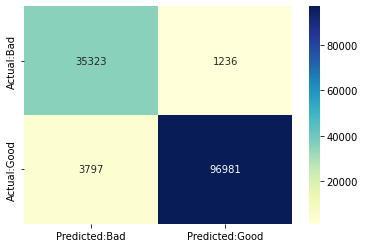

In [46]:
print('Training Accuracy :',lr.score(trainX,trainY))
print('Testing Accuracy :',lr.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(lr.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(lr.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

### MultinomialNB
* Applying Multinomial Naive Bayes to NLP Problems. Naive Bayes Classifier Algorithm is a family of probabilistic algorithms based on applying Bayes' theorem with the “naive” assumption of conditional independence between every pair of a feature.

In [47]:
# create mnb object
mnb = MultinomialNB()

In [48]:
mnb.fit(trainX,trainY)

MultinomialNB()

In [49]:
mnb.score(testX,testY)

0.9580812162782062

*** MultinomialNB gives us 95% accuracy**  

In [50]:
Scores_ml['MultinomialNB'] = np.round(mnb.score(testX,testY),2)

Training Accuracy : 0.97402483926322
Testing Accuracy : 0.9580812162782062

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.92      0.94      0.93     38285
        Good       0.97      0.97      0.97     99052

    accuracy                           0.96    137337
   macro avg       0.95      0.95      0.95    137337
weighted avg       0.96      0.96      0.96    137337


CONFUSION MATRIX


<AxesSubplot:>

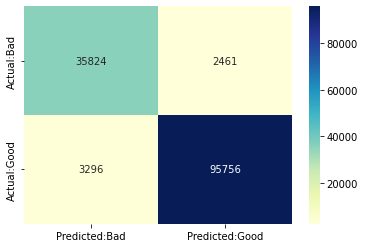

In [51]:
print('Training Accuracy :',mnb.score(trainX,trainY))
print('Testing Accuracy :',mnb.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(mnb.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(mnb.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

<AxesSubplot:ylabel='Accuracy'>

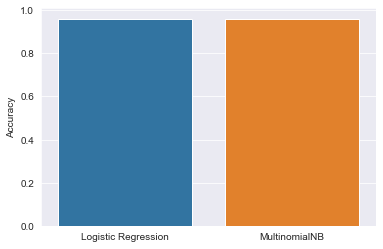

In [52]:
acc = pd.DataFrame.from_dict(Scores_ml,orient = 'index',columns=['Accuracy'])
sns.set_style('darkgrid')
sns.barplot(acc.index,acc.Accuracy)

*** So, Logistic Regression is the best fit model, Now we make sklearn pipeline using Logistic Regression**

In [53]:
pipeline_ls = make_pipeline(CountVectorizer(tokenizer = RegexpTokenizer(r'[A-Za-z]+').tokenize,stop_words='english'), LogisticRegression())
##(r'\b(?:http|ftp)s?://\S*\w|\w+|[^\w\s]+') ([a-zA-Z]+)([0-9]+)  -- these tolenizers giving me low accuray 

In [54]:
trainX, testX, trainY, testY = train_test_split(phish_data.URL, phish_data.Label)

In [55]:
pipeline_ls.fit(trainX,trainY)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(stop_words='english',
                                 tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[A-Za-z]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>)),
                ('logisticregression', LogisticRegression())])

In [56]:
pipeline_ls.score(testX,testY) 

0.9650349141163707

Training Accuracy : 0.9797625780019369
Testing Accuracy : 0.9650349141163707

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.91      0.97      0.94     36611
        Good       0.99      0.96      0.98    100726

    accuracy                           0.97    137337
   macro avg       0.95      0.97      0.96    137337
weighted avg       0.97      0.97      0.97    137337


CONFUSION MATRIX


<AxesSubplot:>

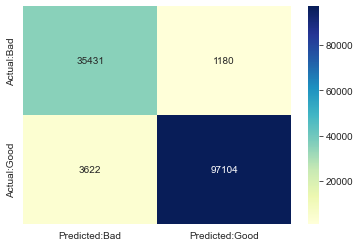

In [57]:
print('Training Accuracy :',pipeline_ls.score(trainX,trainY))
print('Testing Accuracy :',pipeline_ls.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(pipeline_ls.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(pipeline_ls.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [58]:
pickle.dump(pipeline_ls,open('phishing.pkl','wb'))

In [59]:
loaded_model = pickle.load(open('phishing.pkl', 'rb'))
result = loaded_model.score(testX,testY)
print(result)

0.9650349141163707


***That’s it. See, it's that simple yet so effective. We get an accuracy of 98%. That’s a very high value for a machine to be able to detect a malicious URL with. Want to test some links to see if the model gives good predictions? Sure. Let's do it**

* Bad links => this are phishing sites
yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php
fazan-pacir.rs/temp/libraries/ipad
www.tubemoviez.exe
svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt

* Good links => this are not phishing sites
www.youtube.com/
youtube.com/watch?v=qI0TQJI3vdU
www.retailhellunderground.com/
restorevisioncenters.com/html/technology.html

In [60]:
predict_bad = ['yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php','fazan-pacir.rs/temp/libraries/ipad','tubemoviez.exe','svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt']
predict_good = ['youtube.com/','youtube.com/watch?v=qI0TQJI3vdU','retailhellunderground.com/','restorevisioncenters.com/html/technology.html']
loaded_model = pickle.load(open('phishing.pkl', 'rb'))
#predict_bad = vectorizers.transform(predict_bad)
# predict_good = vectorizer.transform(predict_good)
result = loaded_model.predict(predict_bad)
result2 = loaded_model.predict(predict_good)
print(result)
print("*"*30)
print(result2)

['bad' 'bad' 'bad' 'bad']
******************************
['good' 'good' 'good' 'good']
